In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf 
import keras 
import matplotlib.pyplot as plt 
import cv2 
import os 
import PIL 
from pathlib import Path
from PIL import Image

import seaborn as sns
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Dense , Dropout ,Input, BatchNormalization , Activation, GlobalAveragePooling2D
from keras import Sequential

In [2]:
import random
import PIL
import keras
from tensorflow.keras import callbacks


In [3]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    shear_range=0.2,
    validation_split=0.2
)

In [4]:
path=r"C:\Down\Eye_Disease\Dataset"

In [5]:
# load dataset

# Load training dataset without preprocessing
train_ds = datagen.flow_from_directory(
    path,
    
    subset='training',
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=True
    
    
    
)

# Load validation dataset without preprocessing
val_ds =datagen.flow_from_directory(
    path,
    
    subset='validation',
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical'
   
)

Found 3376 images belonging to 4 classes.
Found 841 images belonging to 4 classes.


In [8]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau,CSVLogger

es= EarlyStopping(monitor="val_loss",patience=10,restore_best_weights=True)
mc= ModelCheckpoint("best_eye_model4.keras",monitor="val_loss",save_best_only=True)
csv_logger = CSVLogger("training_log4.csv", append=True)

In [9]:
# ================== 3. Load MobileNetV2 ==================
base = tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet"
)

# Freeze pretrained layers
base.trainable = False

# ================== 4. Create Final Model ==================
model = keras.Sequential([
    base,
    GlobalAveragePooling2D(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(4, activation="softmax")   # ← number of classes
])

# ================== 5. Compile Model ==================
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

# ================== 6. Callbacks ==================
early_stop = tf.keras.callbacks.EarlyStopping(
    patience=8,
    restore_best_weights=True
)
Csv = tf.keras.callbacks.CSVLogger("training_log4.0.csv", append=True)

# ================== 7. Train Model ==================
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop, Csv]
)

# ================== 8. Fine-tuning (Optional but Recommended) ==================
base.trainable = True

# Freeze most layers, train last few
for layer in base.layers[:-40]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[es, mc, csv_logger]
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 59s 528ms/step - accuracy: 0.6979 - loss: 0.7474 - val_accuracy: 0.6718 - val_loss: 0.7648
Epoch 2/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 100s 948ms/step - accuracy: 0.7888 - loss: 0.5438 - val_accuracy: 0.7122 - val_loss: 0.7294
Epoch 3/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 125s 786ms/step - accuracy: 0.8125 - loss: 0.5038 - val_accuracy: 0.6718 - val_loss: 0.8267
Epoch 4/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 50s 476ms/step - accuracy: 0.8235 - loss: 0.4645 - val_accuracy: 0.6956 - val_loss: 0.7374
Epoch 5/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 87s 821ms/step - accuracy: 0.8300 - loss: 0.4390 - val_accuracy: 0.6706 - val_loss: 0.8197
Epoch 6/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 89s 839ms/step - accuracy: 0.8323 - loss: 0.4402 - val_accuracy: 0.7111 - val_loss: 0.6735
Epoch 7/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 141s 821ms/step - accuracy: 0.8486 - loss: 0.4076 - val_accuracy: 0.7039 - val_loss: 0.7457
Epoch 8/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 154s 936ms/step - accuracy: 0.8572 - los

In [70]:
model.evaluate(val_ds)

27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 335ms/step - accuracy: 0.8026 - loss: 0.4900


[0.4899534285068512, 0.8026159405708313]

In [71]:


# predicted probabilities → class index
y_pred = np.argmax(model.predict(val_ds), axis=1)


27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 332ms/step


In [73]:
y_true = val_ds.classes



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
prediction normal


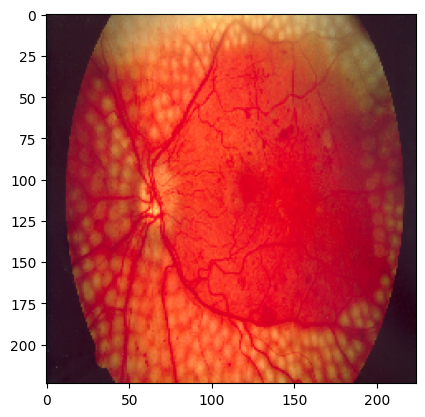

In [75]:
from tensorflow.keras.preprocessing import image


img_path=r"C:\Down\NEI-medialibrary-8324891.png"
img=image.load_img(img_path,target_size=(224,224))
plt.imshow(img)
img=image.img_to_array(img)
img=img/255.0
img=np.expand_dims(img,axis=0)

prediction=model.predict(img)
class_name = list(train_ds.class_indices.keys())

print("prediction",class_name[np.argmax(prediction)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
prediction diabetic_retinopathy


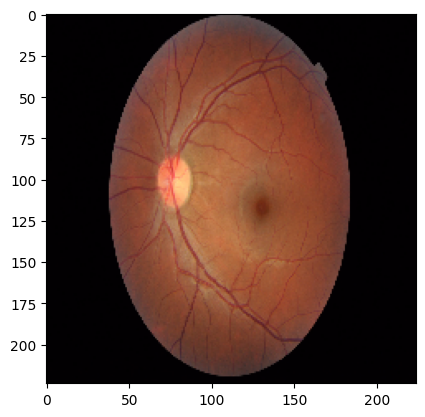

In [76]:
from tensorflow.keras.preprocessing import image


img_path=r"C:\Down\Normal-Fundus.webp"
img=image.load_img(img_path,target_size=(224,224))
plt.imshow(img)
img=image.img_to_array(img)
img=img/255.0
img=np.expand_dims(img,axis=0)

prediction=model.predict(img)
class_name = list(train_ds.class_indices.keys())

print("prediction",class_name[np.argmax(prediction)])

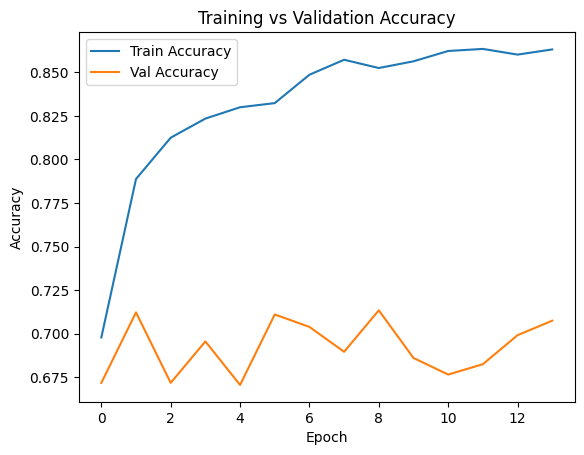

In [77]:
# Accuracy graph
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

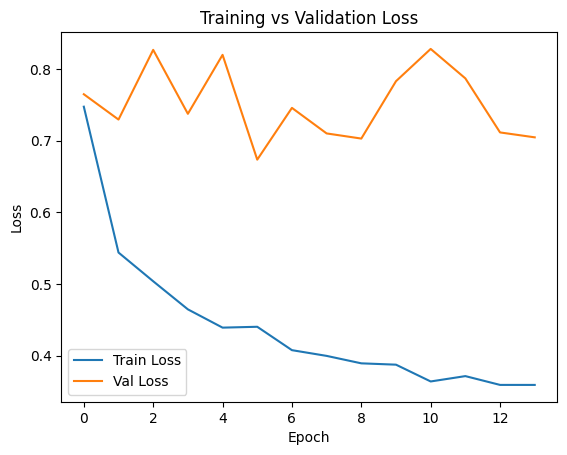

In [78]:
# Loss graph
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 332ms/step


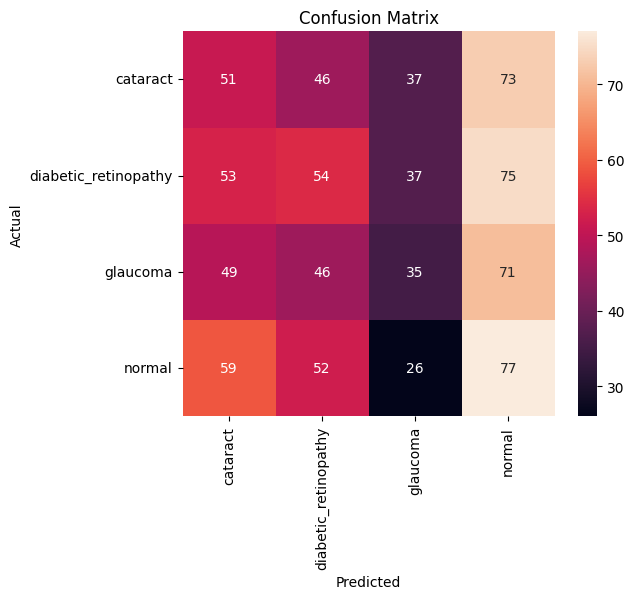

                      precision    recall  f1-score   support

            cataract       0.24      0.25      0.24       207
diabetic_retinopathy       0.27      0.25      0.26       219
            glaucoma       0.26      0.17      0.21       201
              normal       0.26      0.36      0.30       214

            accuracy                           0.26       841
           macro avg       0.26      0.26      0.25       841
        weighted avg       0.26      0.26      0.25       841



In [79]:
# Get true labels
y_true = val_ds.classes

# Predict
y_pred = model.predict(val_ds)
y_pred = np.argmax(y_pred, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=val_ds.class_indices.keys(),
            yticklabels=val_ds.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print(classification_report(y_true, y_pred,
                            target_names=val_ds.class_indices.keys()))